In [239]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [240]:
import sys
sys.path.append('../')
from src.dataset import read_folder
from src.visualization import plot_img

In [241]:
from scipy.spatial import Delaunay

# Load example data

In [242]:
# define Path
PATH = '../LaPa/examples'

In [243]:
# load few examples
images = read_folder(PATH, n = 10, landmarks= 'landmarks', RGB = True)

In [244]:
# choose images to example process
example_img = '10256701615_2'

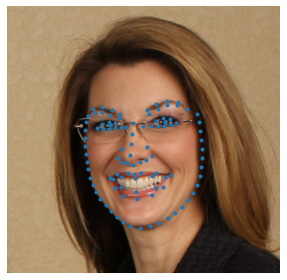

In [245]:
# plot image with landmarks
plot_img(images[example_img]['img'])
plt.plot(images[example_img]['landmarks']()[:,0] , images[example_img]['landmarks']()[:,1], '.')
plt.axis('off')
plt.tight_layout()
plt.show()

# Delaunay triangulation

In [246]:
# apply triangulation of a set of points (landmarks), result are triangles defined by point indices and coordinates
triangles = Delaunay(images[example_img]['landmarks']())

In [247]:
# point indices and coordinates for the three triangles forming the triangulation
triangles.simplices[:3]

array([[41, 33, 34],
       [90, 28, 27],
       [22, 21, 91]], dtype=int32)

In [248]:
# visualization triplots have been created by triangulation
def plot_landmarks_triplot(landmarks, triangles, without_img = True, ax = plt, color = 'black'):
    """
    landmarks - array with landmarks
    triangles - array with triangles
    without_img - bool. Note that the display of the images actually has reversed axes, 
                 to plot with nice view without image we should multiple y axes with -1
    color - color of triplot plot
    """
    ax.triplot(landmarks[:,0], landmarks[:,1] * ((-1) ** without_img), triangles, '--', color = color)
    ax.axis('off')

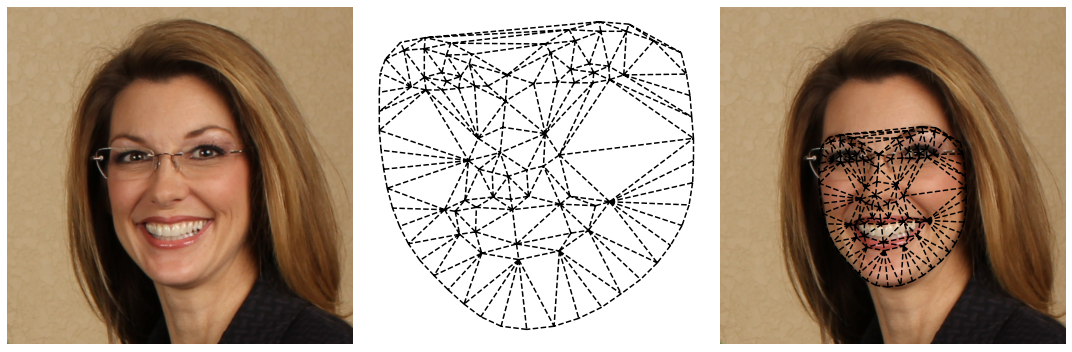

In [249]:
# plot image with triplot mask

# definie subplots space
f, ax = plt.subplots(1,3, figsize=(15,5))

# plot image -- just for base
plot_img(images[example_img]['img'], ax = ax[0])

# plot landmarks triangles
plot_landmarks_triplot(images[example_img]['landmarks'](), triangles.simplices, ax = ax[1])

# plot landmarks triangles with base image, set without_img = False, because image is displayed
plot_img(images[example_img]['img'], ax = ax[2])
plot_landmarks_triplot(images[example_img]['landmarks'](), triangles.simplices, without_img = False, ax = ax[2])
plt.tight_layout()
plt.show()

**it is worth noting** - even if the face is not perfectly symmetrical, we would expect the triangular mask of centered face should be symmetrical (for the sake of points). Unfortunately, using triangularization, we cannot be sure that it will be so.

In [250]:
# (spoiler) bacuse we would like to create symmetrical, we will use theses variables multiple times, we can define
# constant points info for more infomration you can check src/landmarks.py or come back to MeetData notebooks.
LEFT_FACE_SIDE = images[example_img]['landmarks'].points_info['LEFT_FACE_SIDE']
REIGHT_FACE_SIDE = images[example_img]['landmarks'].points_info['REIGHT_FACE_SIDE']
SYMMETRY_LINE = images[example_img]['landmarks'].symmetry_line

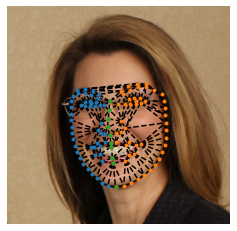

In [251]:
# plot landmarks as triangles considering the side of the face 
plot_landmarks_triplot(images[example_img]['landmarks'](), triangles.simplices, without_img = False)
plt.imshow(images[example_img]['img'])
plt.plot(images[example_img]['landmarks']()[LEFT_FACE_SIDE, 0] , images[example_img]['landmarks']()[LEFT_FACE_SIDE, 1], '.')
plt.plot(images[example_img]['landmarks']()[REIGHT_FACE_SIDE, 0] , images[example_img]['landmarks']()[REIGHT_FACE_SIDE, 1], '.')
plt.plot(images[example_img]['landmarks']()[SYMMETRY_LINE, 0] , images[example_img]['landmarks']()[SYMMETRY_LINE, 1], '.')

I would like to focuse only for specific triangles which will defined using points_sets. Now let's crete funtion that give us possibility to extract intresting us triangles. Function `triangles_specific_points_sets` gives the ability to extract triplets that contain some `include_point_set`, but also that do not contain `inlclude except_point_set`.

In [252]:
def triangles_specific_points_sets(triangles: Delaunay,
                                include_point_set: np.array, 
                                only_points_set: bool = True,
                                except_points_set: np.array = None) -> np.array:
    """
    find triangles which inlude points from include_point_set. 
       Parameters:
        -------
            triangles - scipy.spatial._qhull.Delaunay
                Delaunay object with triangles Indices of the points forming the simplices in the triangulation. 
                For 2-D, the points are oriented counterclockwise.
            include_point_set - array
                with points which have to be included
            only_points_set - bool, default True
                if True, output will inlclude traingle if all points in triangle will be in include_point_set,
                if False, output will inlclude triangle if any point will be in include_point_set
            except_points_set - array
                with points which can not be included. Even if traingle will have points from set include_point_set
        Returns
        -------
            traingles_points: array
                array with triangles Indices of the points forming the simplices in the triangulation. Triangles inlude 
    """
    
    # select traingles considering include_point_set and only_points_set flag
    traingles_in_points_set = []
    for triangle in triangles.simplices:
        if only_points_set:
            len_triangle = len(triangle)
            point_in_points_set = 0
            for point in triangle:
                if point in include_point_set:
                    point_in_points_set += 1
                else:
                    break
            if point_in_points_set == len_triangle:
                traingles_in_points_set.append(triangle)
        else:
            for point in triangle:
                if point in include_point_set:
                    traingles_in_points_set.append(triangle)
                    break
    
    # check if any points in selected triangles not exist in except_points_set
    if except_points_set is not None:
        traingles_in_points_set_without_except_points_set = []
        for triangle in traingles_in_points_set:
            len_triangle = len(triangle)
            point_in_points_set = 0
            for j in triangle:
                if j not in except_points_set:
                     point_in_points_set += 1
                if point_in_points_set == len_triangle:
                        traingles_in_points_set_without_except_points_set.append(triangle)

        return np.array(traingles_in_points_set_without_except_points_set)

    return np.array(traingles_in_points_set)

In [253]:
# select traingles which inluded only points from  LEFT_FACE_SIDE 
left_face_side_traingles = triangles_specific_points_sets(triangles, LEFT_FACE_SIDE, only_points_set = True)

# select traingles which inluded any point from LEFT_FACE_SIDE 
traingles_included_any_left_face_side_points = triangles_specific_points_sets(triangles, LEFT_FACE_SIDE, only_points_set = False)

# select traingles which inluded only points from  REIGHT_FACE_SIDE
reight_face_side_traingles = triangles_specific_points_sets(triangles, REIGHT_FACE_SIDE, only_points_set = True)

# select traingles which inluded any point from REIGHT_FACE_SIDE 
traingles_included_any_reight_face_side_points = triangles_specific_points_sets(triangles, REIGHT_FACE_SIDE, only_points_set = False)

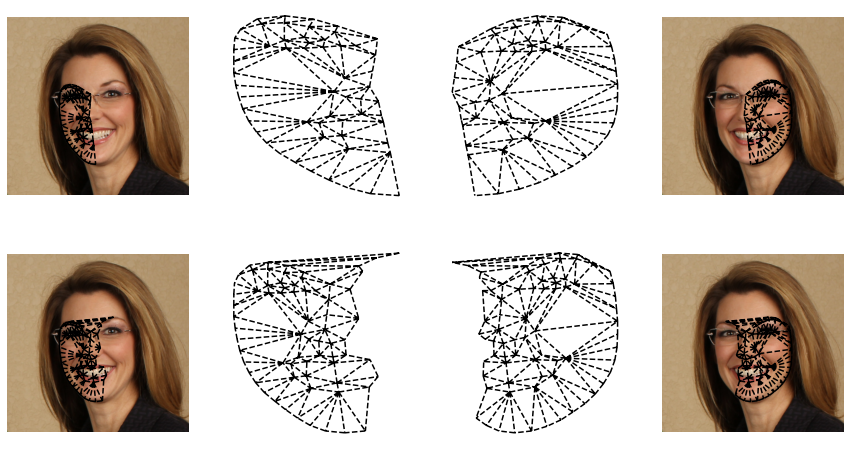

In [254]:
# plot image with triplot mesh grid with specific_points_sets

# definie subplots space
f, ax = plt.subplots(2,4, figsize=(15,8))

#plot image with triangles on left face sides which include only points from LEFT_FACE_SIDE 
plot_img(images[example_img]['img'], ax = ax[0][0])
plot_landmarks_triplot(images[example_img]['landmarks'](), left_face_side_traingles, 
                       without_img = False, ax = ax[0][0] )

#plot triangles mesh grid which include only points from LEFT_FACE_SIDE
plot_landmarks_triplot(images[example_img]['landmarks'](), left_face_side_traingles,
                       without_img = True, ax = ax[0][1] )

#plot triangles mesh grid which include any points from LEFT_FACE_SIDE
plot_landmarks_triplot(images[example_img]['landmarks'](), traingles_included_any_left_face_side_points,
                       without_img = True, ax = ax[1][1] )

#plot image with triangles on left face sides which include any points from LEFT_FACE_SIDE 
plot_img(images[example_img]['img'], ax = ax[1][0])
plot_landmarks_triplot(images[example_img]['landmarks'](), traingles_included_any_left_face_side_points, 
                       without_img = False, ax = ax[1][0] )

#plot image with triangles on left face sides which include only points from REIGHT_FACE_SIDE 
plot_img(images[example_img]['img'], ax = ax[0][3])
plot_landmarks_triplot(images[example_img]['landmarks'](), reight_face_side_traingles, 
                       without_img = False, ax = ax[0][3] )

#plot triangles mesh grid which include only points from REIGHT_FACE_SIDE
plot_landmarks_triplot(images[example_img]['landmarks'](), reight_face_side_traingles, 
                       without_img = True, ax = ax[0][2] )

#plot triangles mesh  grid which include any points from REIGHT_FACE_SIDE
plot_landmarks_triplot(images[example_img]['landmarks'](), traingles_included_any_reight_face_side_points, 
                       without_img = True, ax = ax[1][2] )

#plot image with triangles on left face sides which include any points from REIGHT_FACE_SIDE
plot_img(images[example_img]['img'], ax = ax[1][3])
plot_landmarks_triplot(images[example_img]['landmarks'](), traingles_included_any_reight_face_side_points, 
                       without_img = False, ax = ax[1][3] )

As we can see in the above picture very well, triangles that were defined by the Delaunay algorithm are not symmetrical. 
is it a critical problem? In our case, rather not, but since we have a certain feeling that the facial mesh grid should be defined by symmetrical/mirror triangles, we can create artificially triangles symmetrical grid.

## Symmetrical mesh grid

In [255]:
def create_mirror_traingles(traingles:  np.array , symmetry_dir: dict) -> np.array:
    """
    find triangles mirrored to choosen ones.
    Parameters:
        -------
        traingles: np.array 
            traingles array with landmarks which will be reflected 
        symmetry_dir: dict
            dictonary with corresponding factial points
    Returns
        -------
        mirror_traingles: np.array
            array with traingles mirrored to traingles
            
    """
    mirror_traingles = []
    for triangle in traingles:
        # create new mirrored triangle to triangle
        new_triangle = []
        for point in triangle:
            # for each point in triangle find symmetrical point using symmetry_dir
            new_triangle.append(symmetry_dir[point])
        mirror_traingles.append(np.array(new_triangle))
    return np.array(mirror_traingles)

In [256]:
def triangles_exclusion(triangles:  np.array , exclusion_triangles: np.array) -> np.array:
    """
    find traingles which appear in first dataset (triangles) but do not in the other (exclusion_triangles). 
     Parameters:
        -------
        traingles: np.array 
            base traingles array with landmarks
        exclusion_triangles: np.array
            traingles array which will be excluted from triangles array
     Returns
        -------
        new_triangles: np.array
            array with traingles which do not appears in exclusion_triangles

    """
    new_triangles = []
    for triangle in triangles:
        new_triangles.append(triangle)
        for i in exclusion_triangles:
            if (i == triangle).all():
                new_triangles = new_triangles[:-1]
                break
    return new_triangles

In [257]:
# define symmetry dictonary with all landmarks points with their corresponding points 
symmetry = images[example_img]['landmarks'].symmetry

In [258]:
# create triangles which will be mirror vew of selected traingles using symmetry dicotnary
mirror_triangles_to_left_side_face = create_mirror_traingles(left_face_side_traingles, symmetry)

In [259]:
# do not forgot about conncetion beetwen eyebrowns
traingles_connections = triangles_exclusion(traingles_included_any_left_face_side_points, reight_face_side_traingles)
traingles_connections = triangles_exclusion(traingles_connections, left_face_side_traingles)

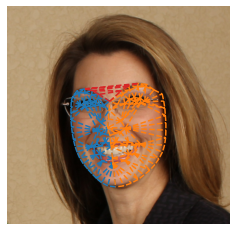

In [260]:
# plot images with created traingle mesh grid
plot_img(images[example_img]['img'])
plot_landmarks_triplot(images[example_img]['landmarks'](), left_face_side_traingles,
                       without_img = False, color = 'tab:blue')
plot_landmarks_triplot(images[example_img]['landmarks'](),
                       mirror_triangles_to_left_side_face, without_img = False, color = 'tab:orange')
plot_landmarks_triplot(images[example_img]['landmarks'](),
                       traingles_connections, without_img = False, color = 'tab:red')

In [261]:
# concate all traingles to create perfect symmetrical mesh grid
symmetrical_traingles = np.concatenate((left_face_side_traingles, mirror_triangles_to_left_side_face, traingles_connections))

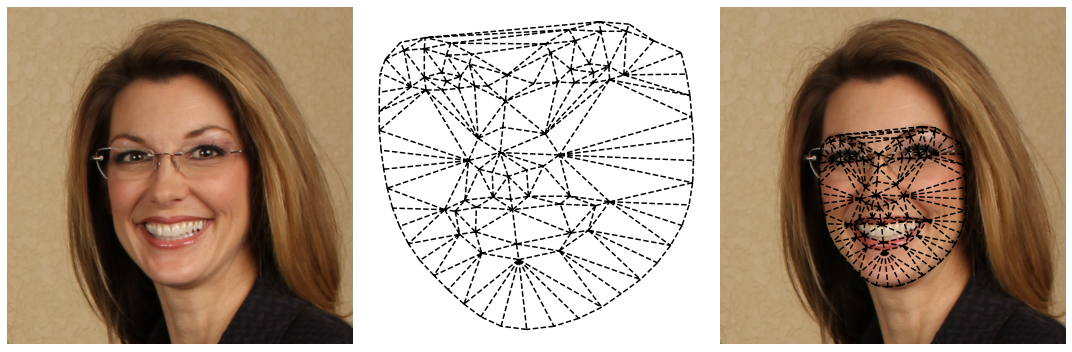

In [262]:
# plot image with triplot symmetrical mesh grid 
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(images[example_img]['img'], ax = ax[0])
plot_landmarks_triplot(images[example_img]['landmarks'](), symmetrical_traingles, ax = ax[1])
plot_img(images[example_img]['img'], ax = ax[2])
plot_landmarks_triplot(images[example_img]['landmarks'](), symmetrical_traingles, False, ax = ax[2])
plt.tight_layout()
plt.show()

In [263]:
#Let's define pipeline function to create symmetrical mesh grid
def symmetrical_mesh_grid(landmarks , symmetry_to_left_face_side = True) -> np.array :
    """ 
    create symmetrical face meshe grid using landmarks
     Parameters:
        -------
        landmarks: Landmarks 
            facial points, which are base to create symmetrical mesh grid using Delaunay triangulation.
        symmetry_to_left_face_side - bool
            choice which face side should be base to create symmetrical mesh grid  (left: True, reight: False)
    """

    triangles = Delaunay(landmarks())
    
    LEFT_FACE_SIDE = landmarks.points_info['LEFT_FACE_SIDE']
    REIGHT_FACE_SIDE = landmarks.points_info['REIGHT_FACE_SIDE']
    SYMMETRY_LINE = landmarks.symmetry_line


    # select traingles which inluded only points from  LEFT_FACE_SIDE 
    left_face_side_traingles = triangles_specific_points_sets(triangles, LEFT_FACE_SIDE, only_points_set = True)

    # select traingles which inluded any point from LEFT_FACE_SIDE 
    traingles_included_any_left_face_side_points = triangles_specific_points_sets(triangles, LEFT_FACE_SIDE, only_points_set = False)

    # select traingles which inluded only points from  REIGHT_FACE_SIDE
    reight_face_side_traingles = triangles_specific_points_sets(triangles, REIGHT_FACE_SIDE, only_points_set = True)

    # select traingles which inluded any point from REIGHT_FACE_SIDE 
    traingles_included_any_reight_face_side_points = triangles_specific_points_sets(triangles, REIGHT_FACE_SIDE, only_points_set = False)
    
    # define symmetry dictonary with all landmarks points with their corresponding points 
    symmetry = landmarks.symmetry

    if symmetry_to_left_face_side: 
        selected_side = left_face_side_traingles
        selected_side_any = traingles_included_any_left_face_side_points
        oposite_side = reight_face_side_traingles
        
    # create triangles which will be mirror vew of selected traingles using symmetry dicotnary
    mirror_triangles_to_left_side_face = create_mirror_traingles(selected_side, symmetry)

    # do not forgot about conncetion beetwen eyebrowns
    traingles_connections = triangles_exclusion(selected_side_any, oposite_side)
    traingles_connections = triangles_exclusion(traingles_connections, selected_side)
    
    # concate all traingles to create perfect symmetrical mesh grid
    symmetrical_traingles = np.concatenate((left_face_side_traingles, mirror_triangles_to_left_side_face, traingles_connections))
    
    return symmetrical_traingles

**What next?**

- You can check more traingulation methods </br>
See:
    </br> - Varshosaz, Masood & Helali, H. & Shojaei, Davood. (2005). The Methods of Triangulation. 

- Now check more images!

- Can we use the same face triangles mesh grid and apply to another images? Check it! :) 

In [264]:
# choose another img
different_example_img =  '10256701615_4'

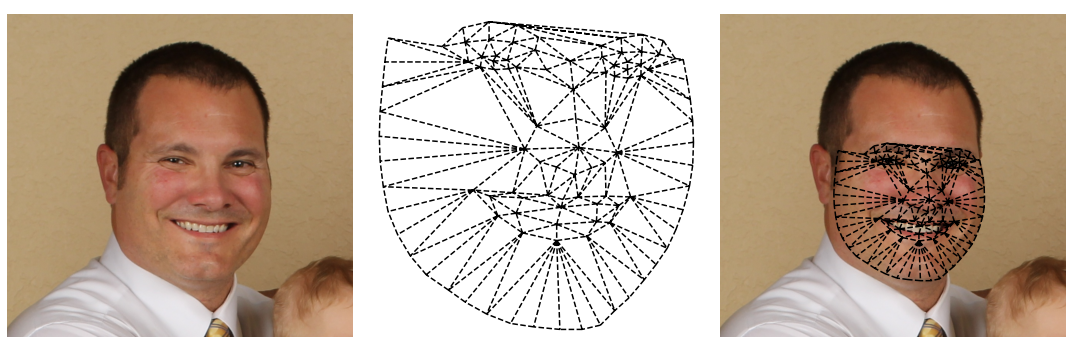

In [269]:
# plot choosen image with triplot symmetrical mesh grid from diffrent image and using traingles mesh grid generated from women
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(images[different_example_img]['img'], ax = ax[0])
plot_landmarks_triplot(images[different_example_img]['landmarks'](), symmetrical_traingles, ax = ax[1])
plot_img(images[different_example_img]['img'], ax = ax[2])
plot_landmarks_triplot(images[different_example_img]['landmarks'](), symmetrical_traingles, False, ax = ax[2])
plt.tight_layout()
plt.show()

In [270]:
# create symmetrical_traingles_new_img using landmarks from new selected image
symmetrical_traingles_new_img = symmetrical_mesh_grid(images[different_example_img]['landmarks'], symmetry_to_left_face_side = True)

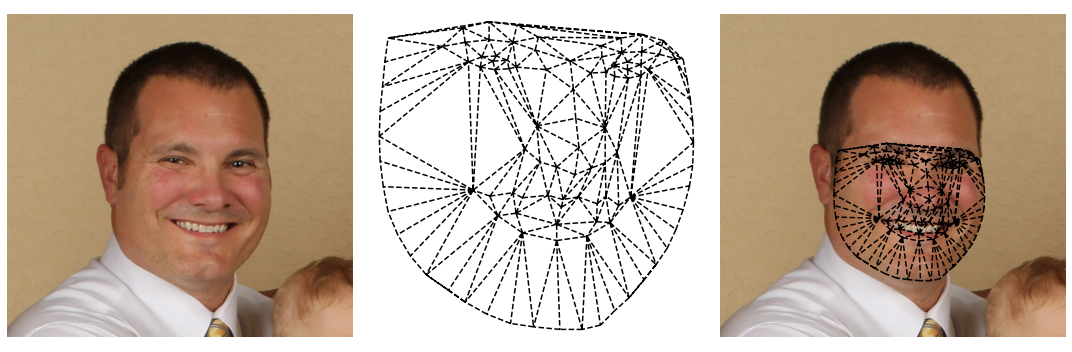

In [271]:
# plot choosen image with triplot symmetrical mesh grid from diffrent image and using new symmetrical_traingles_new_img
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(images[different_example_img]['img'], ax = ax[0])
plot_landmarks_triplot(images[different_example_img]['landmarks'](), symmetrical_traingles_new_img, ax = ax[1])
plot_img(images[different_example_img]['img'], ax = ax[2])
plot_landmarks_triplot(images[different_example_img]['landmarks'](), symmetrical_traingles_new_img, False, ax = ax[2])
plt.tight_layout()
plt.show()

In [272]:
# check if new mesh grid is identical as mesh grid created based on diffrent image

In [273]:
len(symmetrical_traingles_new_img)

173

In [274]:
len(symmetrical_traingles)

167

It is not! Hence... Naturally the question is, should we create a mask every time for every image? Maybe can we use the same mesh grid? Or maybe we have to use the same mesh grid?

To be honest we should create one grid and then apply for evry image. Why? To be sure that we always consider the same triangle. 